In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Flatten,Attention, Concatenate, Input ,Reshape
from tensorflow.keras.optimizers import Adam,RMSprop
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error,precision_score
import numpy as np
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K



In [24]:
file_path = r"data_2/dataset.csv"
data = pd.read_csv(file_path)

In [25]:
data.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9
0,0.184,106401.5980,103157.1785,1293.4311,592,1150,0.7705,0.2313,0.018043
1,0.184,106399.9771,103155.4379,1293.4311,592,1150,0.7705,0.2313,0.018043
2,0.184,106399.9771,103155.4379,1293.4311,592,1150,0.7705,0.2313,0.000000
3,0.184,106400.7710,103156.2771,1293.4311,592,1150,0.7705,0.2313,0.008414
4,0.184,106402.8029,103158.1105,1293.4311,592,1150,0.7705,0.2313,0.008564


In [26]:
data.drop(['Feature9'],axis=1,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Feature1  300 non-null    float64
 1   Feature2  300 non-null    float64
 2   Feature3  300 non-null    float64
 3   Feature4  300 non-null    float64
 4   Feature5  300 non-null    int64  
 5   Feature6  300 non-null    int64  
 6   Feature7  300 non-null    float64
 7   Feature8  300 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 18.9 KB


In [27]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the data
data = scaler.fit_transform(data)

In [28]:
# Create sequences for training (8 rows per year)
def create_sequences(data, seq_length=8, pred_length=20):
    X, y = [], []
    # Ensure the data is in numpy array format
    data = np.array(data)
    
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length])  # Predict the next pred_length steps
        
    return np.array(X), np.array(y)

# Generate sequences
X, y = create_sequences(data, seq_length=8, pred_length=20)

# Print shapes
print(X.shape)
print(y.shape)

(273, 8, 8)
(273, 20, 8)


In [29]:
X, y = create_sequences(data)

In [30]:
# Split the dataset into training and testing sets (use last 20 rows for testing)
X_train = X[:-20]
y_train = y[:-20]
X_test = X[-20:]
y_test = y[-20:]

In [31]:
# y_train = y_train.reshape((-1, 8))  # or y_train = y_train[:, 0, :] if you're dealing with a sequence
# y_test = y_test.reshape((-1, 8))    # same for y_test


In [32]:
print(X_train.shape)
print(y_train.shape)


(253, 8, 8)
(253, 20, 8)


In [33]:
# Build the model with LSTM, GRU, Attention, and Dense layers
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

In [34]:
# LSTM layer
lstm_out = LSTM(64, return_sequences=True)(input_layer)
lstm_out = Dropout(0.2)(lstm_out)

# GRU layer
gru_out = GRU(64, return_sequences=True)(lstm_out)
gru_out = Dropout(0.2)(gru_out)

# Attention layer
attention_out = Attention()([gru_out, gru_out])

# Concatenate LSTM, GRU, and Attention outputs
concat_out = Concatenate()([lstm_out, gru_out, attention_out])

# Flatten the concatenated output
flatten_out = Flatten()(concat_out)

# Dense layers
dense_out = Dense(64, activation='relu')(flatten_out)
dense_out = Dropout(0.2)(dense_out)
output_layer = Dense(20 * 8, activation='linear')(dense_out)

# Reshape to the desired output shape
output_layer = Reshape((20, 8))(output_layer)


In [35]:
print(X_train.shape,y_test.shape)

(253, 8, 8) (20, 20, 8)


In [36]:
# Build the model using the Functional API


# Custom RMSE metric
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Custom MAPE metric
def mape(y_true, y_pred):
    return K.mean(K.abs((y_true - y_pred) / K.clip(K.abs(y_true), K.epsilon(), None))) * 100

# Custom accuracy metric
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

# Custom precision metric
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

from tensorflow.keras.optimizers import Adamax
optimizer = Adamax(learning_rate=0.002)



model = Model(inputs=input_layer, outputs=output_layer)




# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error', rmse, mape, accuracy, precision])

# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 8, 8)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 8, 64)     │     18,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 64)     │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 8, 64)     │     24,960 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 8, 64)     │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 8, 64)     │          0 │ dropout_4[0][0],  │
│ (Attention)         │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 8, 192)    │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ dropout_4[0][0],  │
│                     │                   │            │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1536)      │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     98,368 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 160)       │     10,400 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 20, 8)     │          0 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 152,416 (595.38 KB)

 Trainable params: 152,416 (595.38 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

In [38]:
# Train the model
history = model.fit(X_train, y_train, epochs=150, batch_size=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - loss: 0.8049 - mape: 123.9547 - mean_absolute_error: 0.7214 - precision: 2.9936 - rmse: 0.8933 - val_accuracy: 0.0000e+00 - val_loss: 0.6366 - val_mape: 120.5267 - val_mean_absolute_error: 0.6670 - val_precision: 4.9167 - val_rmse: 0.7979
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.6595 - mape: 142.2231 - mean_absolute_error: 0.6378 - precision: 2.1553 - rmse: 0.8101 - val_accuracy: 0.0000e+00 - val_loss: 0.3901 - val_mape: 127.3761 - val_mean_absolute_error: 0.4884 - val_precision: 6.2045 - val_rmse: 0.6246
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.5786 - mape: 148.7156 - mean_absolute_error: 0.6010 - precision: 1.9312 - rmse: 0.7582 - val_accuracy: 0.0000e+00 - val_loss: 0.2511 - val_mape: 129.4517 - val_mean_absolute_error: 0.3926 - val_precision: 6.8160 - val_rmse: 0.5011
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - a

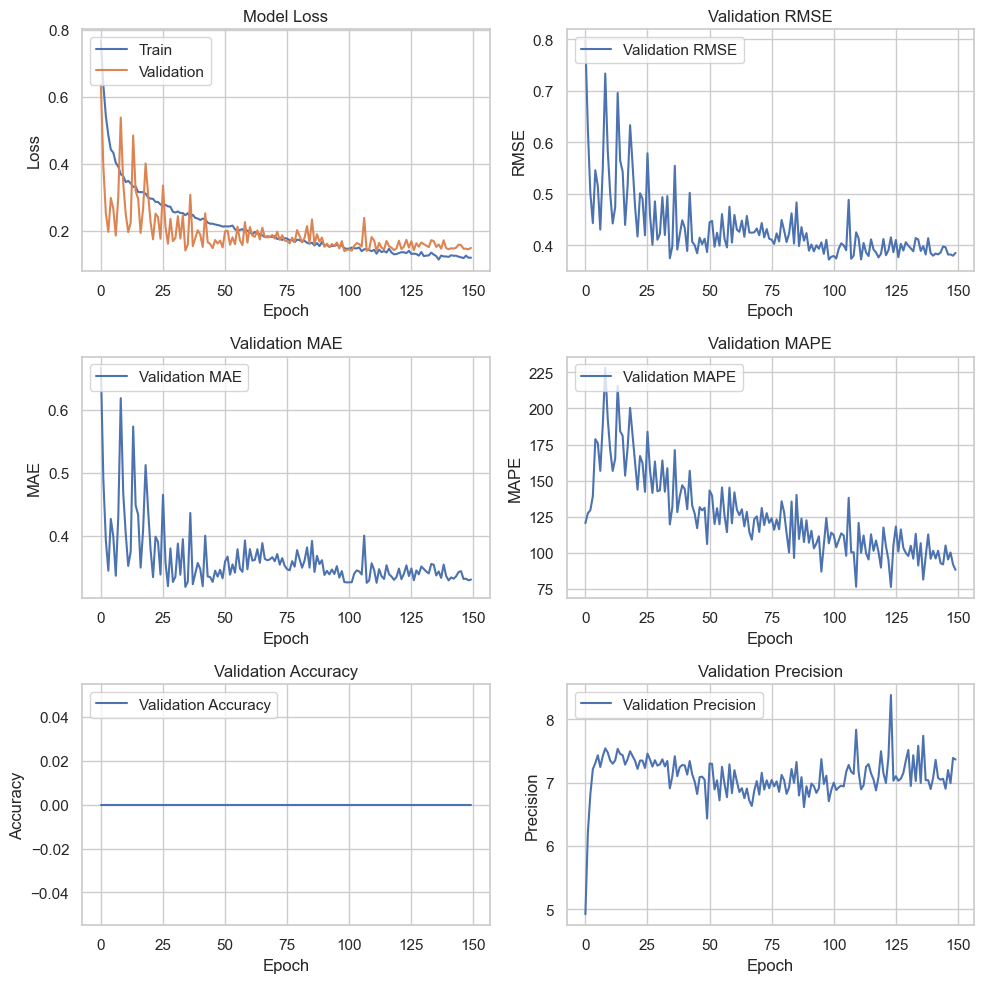

In [39]:
# Extract the metrics from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
val_rmse = history.history['val_rmse']
val_mae = history.history['val_mean_absolute_error']
val_mape = history.history['val_mape']
val_accuracy = history.history['val_accuracy']
val_precision = history.history['val_precision']

# Plot the performance metrics using seaborn
sns.set(style="whitegrid")

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Plot training & validation loss values
sns.lineplot(x=range(len(train_loss)), y=train_loss, ax=axs[0, 0], label='Train')
sns.lineplot(x=range(len(val_loss)), y=val_loss, ax=axs[0, 0], label='Validation')
axs[0, 0].set_title('Model Loss')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].legend(loc='upper left')

# Plot RMSE values
sns.lineplot(x=range(len(val_rmse)), y=val_rmse, ax=axs[0, 1], label='Validation RMSE')
axs[0, 1].set_title('Validation RMSE')
axs[0, 1].set_ylabel('RMSE')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].legend(loc='upper left')

# Plot MAE values
sns.lineplot(x=range(len(val_mae)), y=val_mae, ax=axs[1, 0], label='Validation MAE')
axs[1, 0].set_title('Validation MAE')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].legend(loc='upper left')

# Plot MAPE values
sns.lineplot(x=range(len(val_mape)), y=val_mape, ax=axs[1, 1], label='Validation MAPE')
axs[1, 1].set_title('Validation MAPE')
axs[1, 1].set_ylabel('MAPE')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].legend(loc='upper left')

# Plot Accuracy values
sns.lineplot(x=range(len(val_accuracy)), y=val_accuracy, ax=axs[2, 0], label='Validation Accuracy')
axs[2, 0].set_title('Validation Accuracy')
axs[2, 0].set_ylabel('Accuracy')
axs[2, 0].set_xlabel('Epoch')
axs[2, 0].legend(loc='upper left')

# Plot Precision values
sns.lineplot(x=range(len(val_precision)), y=val_precision, ax=axs[2, 1], label='Validation Precision')
axs[2, 1].set_title('Validation Precision')
axs[2, 1].set_ylabel('Precision')
axs[2, 1].set_xlabel('Epoch')
axs[2, 1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [40]:
# Print the metrics
print("Training Loss: ", train_loss[-1])
print("Validation Loss: ", val_loss[-1])
print("Validation RMSE: ", val_rmse[-1])
print("Validation MAE: ", val_mae[-1])
print("Validation MAPE: ", val_mape[-1])
print("Validation Precision: ", val_precision[-1])


Training Loss:  0.11884628981351852
Validation Loss:  0.14801453053951263
Validation RMSE:  0.38472655415534973
Validation MAE:  0.330404669046402
Validation MAPE:  88.13591766357422
Validation Precision:  7.365714073181152


In [41]:
#Make predictions
y_pred = model.predict(X_test)

# Print predictions
print("Predictions: ", y_pred)

# Calculate and print final evaluation metrics on the test set
final_rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))
final_mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())
final_mape = np.mean(np.abs((y_test.flatten() - y_pred.flatten()) / y_test.flatten())) * 100
final_precision = precision_score((y_test.flatten() > 0.5).astype(int), (y_pred.flatten() > 0.5).astype(int))

print("Final RMSE: ", final_rmse)
print("Final MAE: ", final_mae)
print("Final MAPE: ", final_mape)
print("Final Precision: ", final_precision)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Predictions:  [[[-1.5075035  -1.5930716  -1.6001717  ... -1.1188248   1.3619933
   -1.4421372 ]
  [-1.5256069  -1.5537875  -1.632324   ... -1.0357428   1.4178135
   -1.3887614 ]
  [-1.5156928  -1.6076264  -1.525548   ... -1.060903    1.4458565
   -1.5052351 ]
  ...
  [-1.3593801  -1.3743854  -1.3821052  ... -0.9034008   1.3086367
   -1.3569803 ]
  [-1.4275851  -1.4679546  -1.3648156  ... -0.9460331   1.2236316
   -1.2849902 ]
  [-1.3713567  -1.437009   -1.3670635  ... -0.87898815  1.227767
   -1.3194577 ]]

 [[-1.502134   -1.5852344  -1.5910382  ... -1.112784    1.3586737
   -1.4361103 ]
  [-1.5205667  -1.548575   -1.6234928  ... -1.0305029   1.4107542
   -1.3814107 ]
  [-1.5095645  -1.6009109  -1.5191474  ... -1.0552015   1.4382645
   -1.4981288 ]
  ...
  [-1.3505225  -1.3630806  -1.3717716  ... -0.8961766   1.2974566
   -1.3446465 ]
  [-1.4150194  -1.4559762  -1.3517029  ... -0.9399293   1.2152613
   -1.2753857 ]
  [-1.3611832  -1.4251331  -1.35

In [42]:
# Inverse transform the predictions and the test data
y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1])).reshape(y_pred.shape)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)

columnsnames=['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6','Feature7', 'Feature8']

## Convert predictions and actual values to separate DataFrames using original column names
actual_df = pd.DataFrame(y_test_inverse.reshape(-1, y_test_inverse.shape[-1]), columns=columnsnames)
predicted_df = pd.DataFrame(y_pred_inverse.reshape(-1, y_pred_inverse.shape[-1]), columns=columnsnames)


In [43]:
actual_df

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8
0,0.1208,86623.6320,84400.4660,1162.3136,422.0,1083.0,0.7723,0.1413
1,0.1208,86623.6320,84400.4660,1162.3136,422.0,1083.0,0.7723,0.1413
2,0.1208,86635.5211,84412.6135,1162.3136,422.0,1083.0,0.7722,0.1413
3,0.1293,89857.0463,87010.3655,1197.5529,442.0,1113.0,0.7758,0.1526
4,0.1297,90049.8254,86932.1158,1178.7947,439.0,1094.0,0.7706,0.1535
...,...,...,...,...,...,...,...,...
395,0.1387,92597.5043,90066.2099,1181.6302,449.0,1093.0,0.7577,0.1645
396,0.1386,92571.9423,90039.6155,1181.6302,449.0,1093.0,0.7579,0.1644
397,0.1386,92571.9423,90039.6155,1181.6302,449.0,1093.0,0.7579,0.1644
398,0.1387,92597.5043,90066.2099,1181.6302,449.0,1093.0,0.7577,0.1645


In [44]:
predicted_df

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8
0,0.121725,86493.101562,83864.507812,1164.253418,420.529327,1083.161499,0.775532,0.143096
1,0.121353,86747.914062,83687.953125,1165.994629,425.970795,1086.061401,0.776246,0.144635
2,0.121557,86398.695312,84274.281250,1167.907227,425.411835,1085.183228,0.776605,0.141277
3,0.123311,87390.289062,83696.453125,1168.614990,426.149353,1084.708984,0.777588,0.140430
4,0.123290,87033.320312,84325.179688,1167.729370,429.079834,1088.961792,0.777699,0.142486
...,...,...,...,...,...,...,...,...
395,0.128901,88844.179688,86460.921875,1182.227539,437.812744,1098.335938,0.769346,0.152910
396,0.129272,88983.156250,86590.109375,1176.562622,435.089172,1098.259033,0.769062,0.150222
397,0.127443,89513.968750,86477.320312,1179.364624,434.053711,1094.960938,0.769996,0.149517
398,0.127988,88819.210938,86692.687500,1174.263916,431.329285,1092.515625,0.769288,0.151851


In [49]:
model.save(r'Models/Test/LSTM_test.h5')

In [50]:
from tensorflow.keras.models import load_model
model = load_model(r'Models/Test/LSTM_test.h5')

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Define the optimizer
optimizer = RMSprop(learning_rate=0.001)

# Compile the model with the chosen optimizer
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error', rmse, mape, precision])

# Train the model and record the performance
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))



You can replace `RMSprop` with any other optimizer from the list above and adjust the learning rate as needed.